# How to Plot Level 2 Data from Multiple Granules on a Map

## Overview

Level 2 data from Low Earth Orbit (LEO) satellites are often organized into \"granules\" that contain spatial sets of data that may not match up with the region of interest.  If the region is smaller than the granule the user can create a spatial subset.  If the region is larger than an granule, each granule may be ploted individually, or the data can be aggregated and plotted at once.

## Example

This examle code demonstrates how to aggregate Level 2 data from multiple files and plot it in one figure.

## Prerequisites

This example code is written in Python3 and requires these libraries: glob, numpy, netCDF, matplotlib, and cartopy.  If the files to be agregated are not in netCDF and different reader will have to be used.

In [7]:
import glob
import numpy as np
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os

This how to assumes that the user has searched for the data from the "JPSS-1 CrIS Level 2 CLIMCAPS: Atmosphere cloud and surface geophysical state V2" data over the Gulf of Mexico within a bounding box defined by the following pairs of longitude and latitude (-100, 15) and (-75, 30) on 2021-09-23.  A similar search can be achieved by using the GES DISC API.  For the purposes of this how-to document we list the urls of the Level 2 files obtained from this search below.

Dataset Citation:

Chris Barnet (2019), Sounder SIPS: JPSS-1 CrIS Level 2 CLIMCAPS: Atmosphere cloud and surface geophysical state V2, Greenbelt, MD, USA, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: [Data Access Date], 10.5067/LESQUBLWS18H

The following block of code downloads the Level 2 files in the region of interest to the current directory and reads the list of local files into a list called "datafiles".

In [3]:
listofurls = ['https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0606.m06.g062.L2_CLIMCAPS_RET.std.v02_53.G.211223053311.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0612.m06.g063.L2_CLIMCAPS_RET.std.v02_53.G.211223053331.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0748.m06.g079.L2_CLIMCAPS_RET.std.v02_53.G.211223053551.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0754.m06.g080.L2_CLIMCAPS_RET.std.v02_53.G.211223053611.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1724.m06.g175.L2_CLIMCAPS_RET.std.v02_53.G.211223055024.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1900.m06.g191.L2_CLIMCAPS_RET.std.v02_53.G.211223055205.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1906.m06.g192.L2_CLIMCAPS_RET.std.v02_53.G.211223055225.nc']

fname='dataurls.txt'
f = open(fname,'w')
for url in listofurls:
    f.write(url+'\n')
f.close()


os.system('wget -i dataurls.txt')



The following block of code plots the surface Air Temperature from the first file in the list.

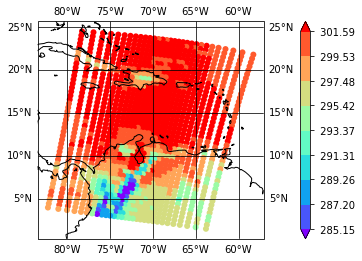

In [4]:
# glob will read in the relevant datafiles to plot.
datafiles = glob.glob('*.nc')

# these are the relevant science variable
varname = 'surf_air_temp'
qcvarname =  'surf_air_temp_qc'

# this reads the data from the first file in the 
fid = netCDF4.Dataset(datafiles[0] ,mode='r',format='NETCDF4')
lat = fid.variables['lat'][:]
lon = fid.variables['lon'][:]
sol_zen = fid.variables['sol_zen'][:]
data = fid.variables[varname][:]
dataqc = fid.variables[qcvarname][:]

# this sets up the plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,linewidth=0.75, color='black')
lowerlimit = data.min()
upperlimit = data.max()
ncolors=10
cmap=plt.cm.rainbow
bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
c=plt.scatter(lon,lat,c=data, cmap=cmap, norm=norm, edgecolor='black', linewidth=0, vmin=lowerlimit, vmax=upperlimit)
plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.show()
fid.close()

The next step is to loop over all of the granules to aggregate the data to be plotted.

In [19]:
# initialize the array into which the data will be aggregated.
lon_agg = np.array([])
lat_agg = np.array([])
sol_zen_agg = np.array([])
data_agg = np.array([])
dataqc_agg = np.array([])

for i,file in enumerate(datafiles):
    # open the file
    fid = netCDF4.Dataset( file ,mode='r',format='NETCDF4')

    # read the longitude, latitude, and other relevant variables
    lat = fid.variables['lat'][:]
    lon = fid.variables['lon'][:]
    sol_zen = fid.variables['sol_zen'][:]
    data = fid.variables[varname][:]
    dataqc = fid.variables[qcvarname][:]
    
    lon_agg = np.append(lon_agg,lon.flatten().copy())
    lat_agg = np.append(lat_agg,lat.flatten().copy())
    sol_zen_agg = np.append(sol_zen_agg,sol_zen.flatten().copy())
    data_agg = np.append(data_agg,data.flatten().copy()) 
    dataqc_agg = np.append(dataqc_agg,dataqc.flatten().copy()) 

The following block of code plots all of the aggregated data.

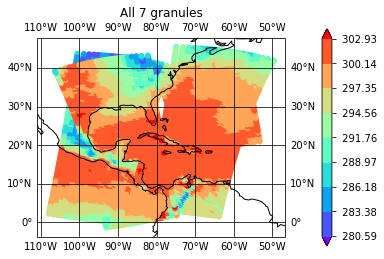

In [9]:
# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg,lat_agg,c=data_agg, cmap=cmap, norm=norm, edgecolor='black', linewidth=0, vmin=lowerlimit, vmax=upperlimit) # s=15 will make the symbols smaller

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('All Data')
plt.show()


plt.colorbar(ax=ax, orientation="horizontal", pad=0.110, ticks=bounds)

Now we can use the solar zenith angle variable to only select the daytime observation (i.e., when sol_zen_agg < 90).

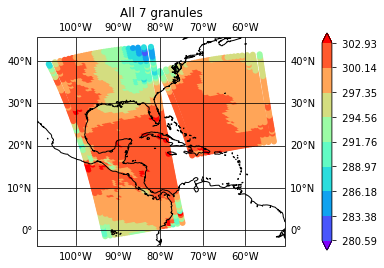

In [10]:
daymask = sol_zen_agg < 90.

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[daymask],lat_agg[daymask],c=data_agg[daymask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, vmin=lowerlimit, vmax=upperlimit) # s=15 will make the symbols smaller

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Day Data')
plt.show()

Now just plot the nighttime footprints

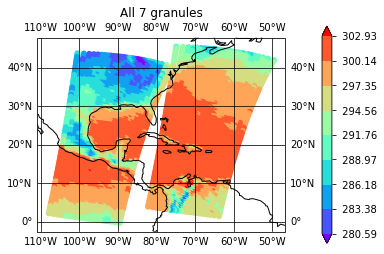

In [12]:
nightmask = sol_zen_agg >= 90

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[nightmask],lat_agg[nightmask],c=data_agg[nightmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, vmin=lowerlimit, vmax=upperlimit) # s=15 will make the symbols smaller

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Night Data')
plt.show()

The next block of code uses the solar zenith angle and the quality flag to creates a mask that will just plot the good data at night

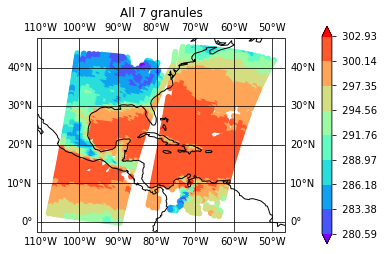

In [22]:
gooddatamask = np.logical_or(dataqc_agg == 0, dataqc_agg == 1)
nightmask = sol_zen_agg >= 90

goodnightmask = np.logical_and(gooddatamask,nightmask)


# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[goodnightmask],lat_agg[goodnightmask],c=data_agg[goodnightmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, vmin=lowerlimit, vmax=upperlimit) # s=15 will make the symbols smaller

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Good Night')
plt.show()